# <center>Autoencodeur : débruitage des photos</center>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

2024-01-19 16:35:22.225660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 16:35:22.225771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 16:35:22.316366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 16:35:22.543371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 16:35:24.659065: W tensorflow/compiler/tf2

### Congfiguration de l'environnement pour l'entraînement

L'entraînement de notre autoencodeur se fera avec des images de dimensions 128x128.

In [2]:
BATCH_SIZE = 32
COLOR = 3   #1 pour images en noir et blanc, 3 pour images couleur
IMAGE_SIZE = (128, 128)
SHAPE = IMAGE_SIZE[0] * IMAGE_SIZE[1]
EPOCHS = 50
SAVE_MODEL_DENOISE = "denoiser.h5"

In [3]:
def display_image(X, n):
    plt.figure(figsize=(6, 6))
    for i in range(n):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Import des données

In [4]:
def get_dataset():
    return tf.keras.utils.image_dataset_from_directory(
        "Datasets/Dataset Livrable 2",
        labels=None,
        label_mode=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="both",
        interpolation='area' #area pour rétrecir / bicubic pour élargir
    )

In [5]:
train_set, validation_set = get_dataset()

Found 10000 files belonging to 1 classes.
Using 8000 files for training.
Using 2000 files for validation.


2024-01-19 16:35:47.608757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 16:35:47.996129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 16:35:47.996186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 16:35:48.001644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 16:35:48.001771: I external/local_xla/xla/stream_executor

### Exploration et visualisation des données

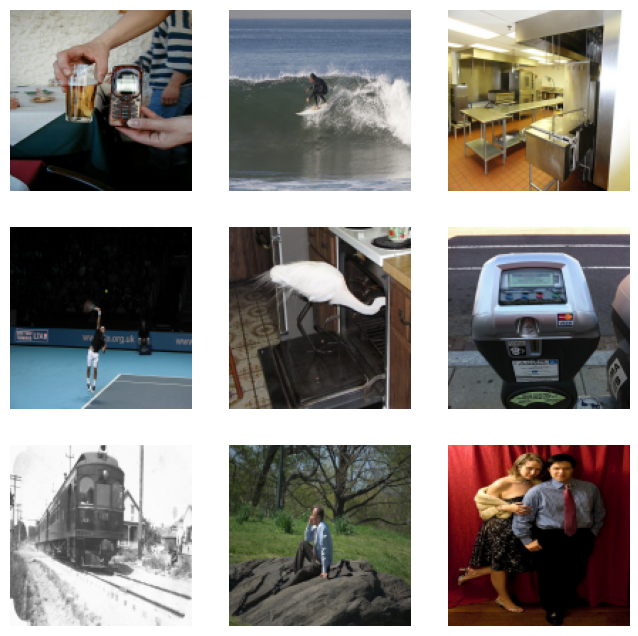

In [6]:
plt.figure(figsize=(8, 8))
for images in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
print("Shape du dataset :")
for batch in train_set.take(1):
    print(batch[0].shape)

Shape du dataset :
(128, 128, 3)


### Convertir les tensors en numpy arrays

In [8]:
images_train, images_validation = [], []

for image_batch in train_set:
    images_train.extend(image_batch.numpy())

In [9]:
for image_batch in validation_set:
    images_validation.extend(image_batch.numpy())

In [10]:
images_train = np.array(images_train)
images_validation = np.array(images_validation)

In [11]:
X_train = images_train
y_train = np.copy(X_train)

X_validation = images_validation
y_validation = np.copy(X_validation)

Ici, on ne prend que 10% des photos pour des raisons de puissance de calcul.

In [12]:
X_train = X_train[:(int(len(X_train)/10))]
y_train = y_train[:(int(len(y_train)/10))]
X_validation = X_validation[:(int(len(X_validation)/10))]
y_validation = y_validation[:(int(len(y_validation)/10))]

Puis on normalise la valeur de chaque pixel entre 0 et 1.

In [14]:
X_train = X_train.astype('float32') / 255.
X_validation = X_validation.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), IMAGE_SIZE[0], IMAGE_SIZE[1], COLOR))
X_validation = np.reshape(X_validation, (len(X_validation), IMAGE_SIZE[0], IMAGE_SIZE[1], COLOR))

In [15]:
print("X_train shape : {}".format(str(X_train.shape)))
print("y_train shape : {}".format(str(y_train.shape)))
print("X_validation shape : {}".format(str(X_validation.shape)))
print("y_validation shape : {}".format(str(y_validation.shape)))

X_train shape : (800, 128, 128, 3)
y_train shape : (800, 128, 128, 3)
X_validation shape : (200, 128, 128, 3)
y_validation shape : (200, 128, 128, 3)


### Autoencodeur : entraînement

Nous allons utiliser un autoencodeur convolutif 3 couches pour débruiter nos photos :
- 3 couches de convolution pour l'encodeur, dimension des photos 128x128(input) -> 64x64 -> 32x32 -> 16x16
- 3 couches de convolution pour le décodeur, dimension des photos 16x16 -> 32x32 -> 64x64 -> 128x128(output)

Commençons par bruiter nos photos et réajuster les pixels dont la valeur a dépassé les bornes [0;1].

Nous bruitons les photos avec un facteur de 0,5 pour que notre autoencodeur puisse s'adapter à des photos très bruitées.

In [16]:
noise_factor = 0.5
X_train_noisy = X_train + np.random.normal(scale=noise_factor, size=X_train.shape)
X_validation_noisy = X_validation + np.random.normal(scale=noise_factor, size=X_validation.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_validation_noisy = np.clip(X_validation_noisy, 0., 1.)

Ensuite, on affiche 9 photos et leur version bruitée.

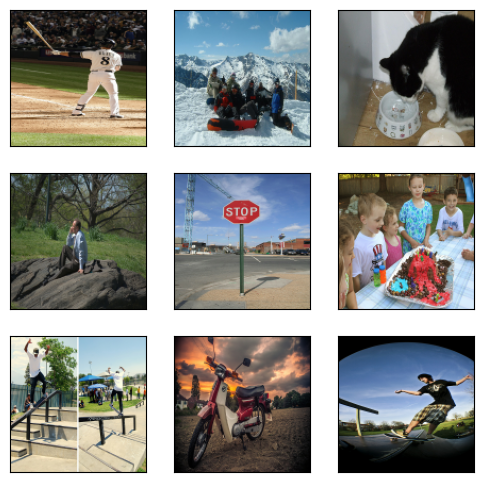

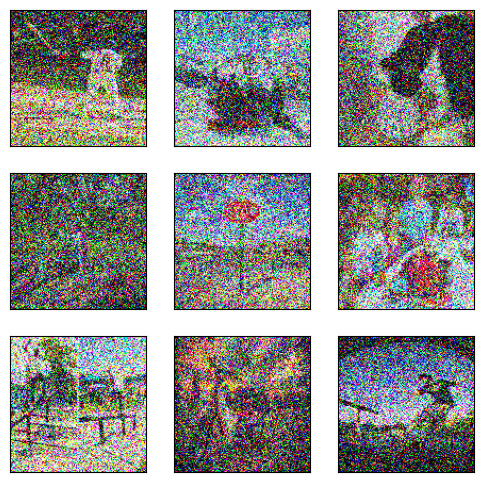

In [17]:
display_image(X_train, n=9)
display_image(X_train_noisy, n=9)

L'autoencodeur se divise en 2 parties : l'encodeur et le décodeur.

Le but de l'encodeur est de prendre les photos d'entrée et de les transformer en une représentation compacte. Cette représentation interne doit indentifier les caractéristiques essentielles des photos tout en réduisant leur dimensionnalité.

Voici le code de l'encodeur utilisant trois couches de convolution :

In [18]:
input_img = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], COLOR))

x = Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = MaxPooling2D()(x)

x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPooling2D()(x)

x = Conv2D(128, 3, padding="same", activation="relu")(x)
encoded = MaxPooling2D()(x)

Le décodeur a pour objectif de prendre les photos encodées et de les reconstruire dans leur forme d'origine. Il tente de générer une version proche des données d'entrée à partir de la représentation apprise par l'encodeur.

Voici son code :

In [26]:
x = Conv2D(128, 3, padding="same", activation="relu")(encoded)
x = UpSampling2D()(x)

x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)

x = Conv2D(32, 3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)

decoded = Conv2D(COLOR, 3, padding="same", activation="sigmoid")(x)

Enfin, compilons le model autoencodeur avant de l'entraîner :

In [27]:
autoencoder = Model(inputs = input_img, outputs = decoded)
autoencoder.compile(
    optimizer="adam",
    loss=keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error")
)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 


 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 

Ici, nous préparons un callback early stopping avec une patience égale au dixième du nombre totale d'epochs, que nous allons appliquer sur notre autoencodeur pour arrêter l'entraînement avant surapprentissage.

In [28]:
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=(EPOCHS/10))

In [29]:
history = autoencoder.fit(x=X_train_noisy, y=X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_validation_noisy, X_validation),
    callbacks=[callback_earlystopping]
)

Epoch 1/50
25/25 [==============================] - 9s 185ms/step - loss: 0.0333 - val_loss: 0.0212
Epoch 2/50
25/25 [==============================] - 3s 121ms/step - loss: 0.0198 - val_loss: 0.0176
Epoch 3/50
25/25 [==============================] - 3s 128ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 4/50
25/25 [==============================] - 3s 135ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 5/50
25/25 [==============================] - 4s 152ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 6/50
25/25 [==============================] - 3s 132ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 7/50
25/25 [==============================] - 3s 125ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 8/50
25/25 [==============================] - 3s 128ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 9/50
25/25 [==============================] - 3s 129ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 10/50
25/25 [==============================] - 3s 124ms/step - loss: 0.0114 - val_loss: 0.0118

### Autoencodeur : résultats

Affichons un graphique représentant la loss sur le dataset de train et celui de validation :

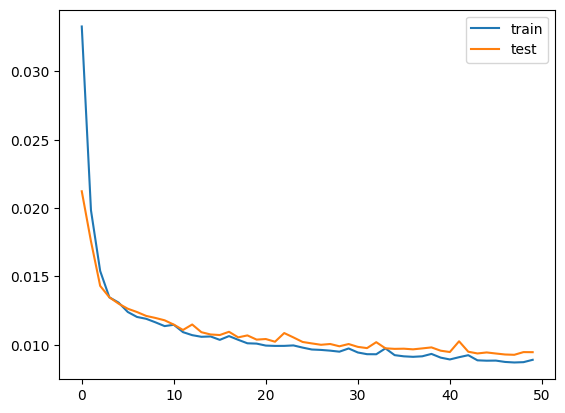

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Terminons par un exemple d'utilisation de notre autoencodeur en débruitant des photos bruitées. Ci-dessous sont affichées 9 photos, leur version bruitée et leur version débruitée par l'autoencodeur.

7/7 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


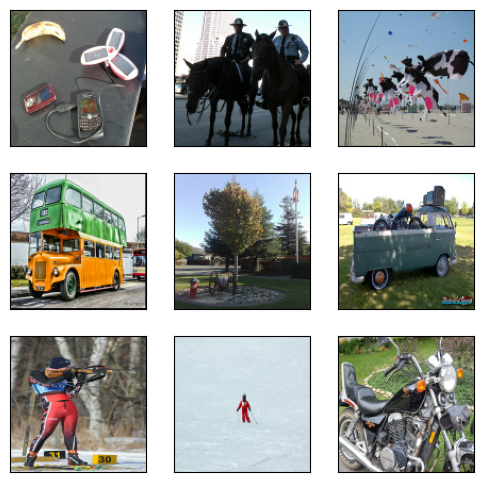

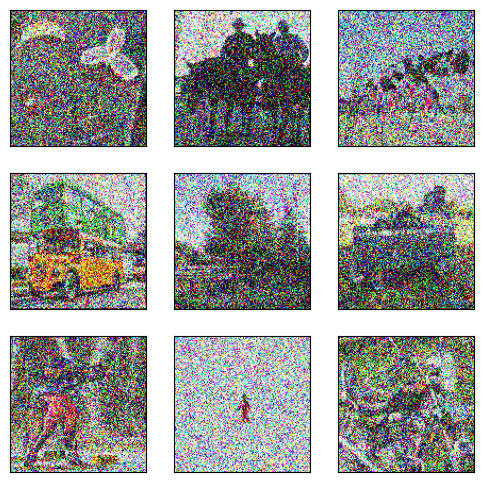

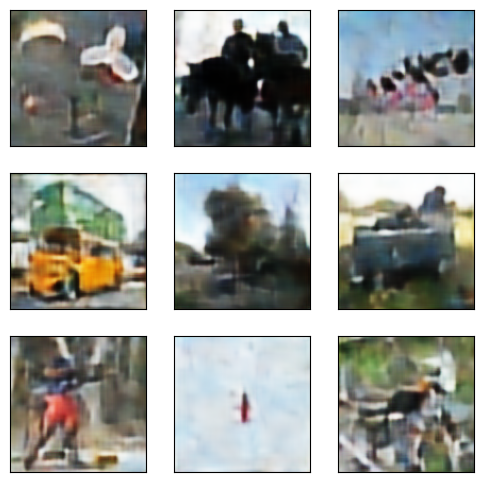

In [32]:
decoded_imgs = autoencoder.predict(X_validation_noisy)
display_image(X_validation, n=9)
display_image(X_validation_noisy, n=9)
display_image(decoded_imgs, n=9)

Sauvegardons le model dans le fichier denoiser.h5

In [31]:
autoencoder.save(SAVE_MODEL_DENOISE)

/home/gitan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Conclusion

On a donc un bon autoencodeur avec une loss de 1%. Les photos sont bien reconstruites après débruitage et devraient permettre l'éxecution de futures actions comme le captioning.